# Bayesian network model of predator-prey interactions

## 1. Description

Here, I build a Bayesian network implementation of the DAG where there is no feedback between the predator and the prey's behavior within a match.

Our objective is to use causal inference to model the predator-prey interaction as it changes throughout the predator's experience. Our DAG explains how we expect the system to work.

## 2. Prepare the session

I start by importing the librairies that I'll need to build the network.

In [1]:
# For Bayesian networks
import bnlearn as bn

# For cross validation
from sklearn.model_selection import train_test_split

# For data manipulations
from pathlib import Path
import pandas as pd
import numpy as np

I also define the path to the "outputs" folder of the project to save the trained model and the testing data.

In [2]:
from joblib import dump
import os

# Define the parent directory
parent_dir = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir)
)

# Define the subfolder directory
output_folder = os.path.join(
    parent_dir, "outputs"
)

# Name of the outpout files
file_name1 = "test-data.joblib"
file_name2 = "BayesNet-fit.joblib"

# Create the full path
output_path1 = os.path.join(
    output_folder, file_name1

)
output_path2 = os.path.join(
    output_folder, file_name2

)

## 3. Import the data

I import the data to build the network.

In [3]:
# Specify the parent folder
notebook_dir = Path.cwd()
parent_folder = notebook_dir.parent.parent

# Data path
data_subfolder = "data"
file_name = "FraserFranco-etal-XXXX.csv"

# Full path to data file
file_path = parent_folder / data_subfolder / file_name

# Import dataset
dat = pd.read_csv(file_path, index_col = None)

### 3.1 Visualize the data structure

Let's start by checking the data

In [4]:
dat.head()

,match_id,predator_id,xp_level,timestamp,game_mode,realm_id,environment_id,avatar_id,game_duration,prey_avg_rank,...,chase_count,chase_count_success,attacks_count,prey_avg_heal_count,prey_var_heal_count,chase_success_ratio,prior_prey_speed,prior_prey_heal,prior_success,time_lag
0,DHCF1PHC,pred100494,novice,2021-01-02 14:47:16,Online,Yamaoka Estate,Family Residence,Wraith,399.848999,11.75,...,5,1,2,1.25,3.583333,0.2,NaN,NaN,NaN,NaN
1,BHJFA1I0,pred100494,novice,2021-01-02 14:57:02,Online,The Macmillan Estate,Groaning Storehouse,Wraith,319.134979,11.75,...,8,0,0,0.00,0.000000,0.0,2.129557,1.25,0.0,9.766133
2,PMM9CDDR,pred100494,novice,2021-01-02 15:08:18,Online,Silent Hill,Midwich Elementary School,Doctor,687.513123,15.25,...,19,0,6,1.75,0.916667,0.0,2.278671,0.00,0.0,11.271783
3,3NT75SH7,pred100494,novice,2021-01-02 15:30:29,Online,Autohaven Wreckers,Blood Lodge,Huntress,528.620361,11.25,...,11,0,7,1.75,1.583333,0.0,1.962961,1.75,0.0,22.176050
4,MNL0ZWA5,pred100494,novice,2021-01-02 15:46:26,Online,Grave of Glenvale,Dead Dawg Saloon,Hillbilly,409.839844,14.50,...,4,0,0,0.00,0.000000,0.0,2.415156,1.75,0.0,15.946550


In [5]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100062 entries, 0 to 100061
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   match_id               100062 non-null  object 
 1   predator_id            100062 non-null  object 
 2   xp_level               100062 non-null  object 
 3   timestamp              100062 non-null  object 
 4   game_mode              100062 non-null  object 
 5   realm_id               100062 non-null  object 
 6   environment_id         100062 non-null  object 
 7   avatar_id              100062 non-null  object 
 8   game_duration          100062 non-null  float64
 9   prey_avg_rank          100062 non-null  float64
 10  total_xp_pred          100062 non-null  int64  
 11  cumul_xp_pred          100062 non-null  int64  
 12  hunting_success        100062 non-null  int64  
 13  points_predator        100062 non-null  int64  
 14  pred_speed             100062 non-nu

In [6]:
print("Colum names:", dat.columns)

Colum names: Index(['match_id', 'predator_id', 'xp_level', 'timestamp', 'game_mode',
       'realm_id', 'environment_id', 'avatar_id', 'game_duration',
       'prey_avg_rank', 'total_xp_pred', 'cumul_xp_pred', 'hunting_success',
       'points_predator', 'pred_speed', 'prey_avg_speed',
       'predicted_mean_speed', 'predicted_sigma_speed', 'cluster',
       'hunting_type', 'chase_count', 'chase_count_success', 'attacks_count',
       'prey_avg_heal_count', 'prey_var_heal_count', 'chase_success_ratio',
       'prior_prey_speed', 'prior_prey_heal', 'prior_success', 'time_lag'],
      dtype='object')


## 4. Build the Bayesian network

Here, I use my expertise and knowledge of the system to build the network. In this manuscript, we suggest a causal model of predator-prey interactions, and we thus build our model based on our beliefs on how the system works.

### 4.1 Discretize the continuous variables

I start by discretizing the continuous variables that I'll be using in the network. I will use a quantile-based discretization with 5 bins.

In [7]:
# Function to create bins
def create_bins(data, column, num_bins = 5):
    data[f"{column}_bin"] = pd.qcut(
        x = data[column],
        q = num_bins
    )

# Columns to bin
columns_to_bin = [
    "prey_avg_speed",
    "time_lag",
    "prior_prey_speed",
    "game_duration"
]

# Run the function
for column in columns_to_bin:
    create_bins(dat, column)

I need to do discretize the variable chase success ratio manually since the pd.cut() function seems to produce bins with negative values, which isn't possible for a ratio.

In [8]:
column_name = "chase_success_ratio"

# Define the bin edges manually based on the range of the data
min_value = dat[column_name].min()
max_value = dat[column_name].max()
bin_edges = [
    min_value,
    0.2 * (max_value - min_value),
    0.4 * (max_value - min_value),
    0.6 * (max_value - min_value),
    0.8 * (max_value - min_value),
    max_value
]

# Apply manual binning
dat["chase_success_ratio_bin"] = pd.cut(
    x = dat["chase_success_ratio"],
    bins = bin_edges
)

# Check the result
print(dat["chase_success_ratio_bin"].value_counts())

(0.2, 0.4]    44300
(0.4, 0.6]    25650
(0.0, 0.2]    20658
(0.6, 0.8]     5336
(0.8, 1.0]      692
Name: chase_success_ratio_bin, dtype: int64


### 4.2 Select variables for the Bayesian network

I then subset the variables that I will use for the model.

In [9]:
# Select relevant variables
selected_variables = [
    "xp_level",
    "time_lag_bin",
    "hunting_type",
    "hunting_success",
    "prey_avg_speed_bin",
    "prior_success",
    "prior_prey_speed_bin",
    "chase_success_ratio_bin",
    "game_duration_bin"
]

# Subset the data
subset = dat[selected_variables]
subset

# Drop the first row for every player ID (NaN)
subset = subset.dropna()

# Convert success to integer again
subset['prior_success'] = subset['prior_success'].round().astype(int)

subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96409 entries, 7 to 100061
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   xp_level                 96409 non-null  object  
 1   time_lag_bin             96409 non-null  category
 2   hunting_type             96409 non-null  object  
 3   hunting_success          96409 non-null  int64   
 4   prey_avg_speed_bin       96409 non-null  category
 5   prior_success            96409 non-null  int64   
 6   prior_prey_speed_bin     96409 non-null  category
 7   chase_success_ratio_bin  96409 non-null  category
 8   game_duration_bin        96409 non-null  category
dtypes: category(5), int64(2), object(2)
memory usage: 4.1+ MB


In [10]:
subset.head()

,xp_level,time_lag_bin,hunting_type,hunting_success,prey_avg_speed_bin,prior_success,prior_prey_speed_bin,chase_success_ratio_bin,game_duration_bin
7,novice,"(18.035, 25.191]",ambush-flexible,1,"(2.153, 2.35]",0,"(2.672, 3.664]","(0.0, 0.2]","(706.504, 831.195]"
8,novice,"(359.33, 201831.686]",ambush-flexible,0,"(0.619, 2.153]",1,"(2.153, 2.35]","(0.0, 0.2]","(518.858, 614.24]"
9,novice,"(25.191, 359.33]",ambush-flexible,0,"(0.619, 2.153]",0,"(0.619, 2.153]","(0.0, 0.2]","(831.195, 4217.349]"
11,novice,"(25.191, 359.33]",ambush-flexible,1,"(2.153, 2.35]",0,"(2.672, 3.664]","(0.4, 0.6]","(518.858, 614.24]"
15,novice,"(5.96, 14.699]",ambush-flexible,0,"(2.35, 2.506]",0,"(0.619, 2.153]","(0.2, 0.4]","(180.017, 518.858]"


### 4.2 Build the Bayesian network structure

Here, I build the relationships (edges) between the variables (nodes).

The model goes like this :

**Edges for prior success**
- prior prey speed --> prior hunting success

**Edges for hunting type**
- experience --> hunting type
- prior prey speed --> hunting type
- prior success --> hunting type
- time lag --> hunting type

**Edges for chase success ratio**
- time lag --> chase success ratio
- experience --> chase success ratio
- hunting type --> chase success ratio
- prey speed --> chase success ratio

**Edges for prey speed**
- hunting type --> prey speed

**Edges for hunting success**
- chase success ratio --> hunting success
- hunting type --> hunting success
- prey speed --> hunting success

**Control**
- game duration --> hunting success


In [11]:
edges = [
    # Edges for prior hunting success
    ("prior_prey_speed_bin", "prior_success"),
    # Edges for hunting type
    ("xp_level", "hunting_type"),
    ("prior_success", "hunting_type"),
    ("time_lag_bin", "hunting_type"),
    ("prior_prey_speed_bin", "hunting_type"),
    # Edges for chase success ratio
    ("time_lag_bin", "chase_success_ratio_bin"),
    ("xp_level", "chase_success_ratio_bin"),
    ("hunting_type", "chase_success_ratio_bin"),
    ("prey_avg_speed_bin", "chase_success_ratio_bin"),
    # Edges for prey speed
    ("hunting_type", "prey_avg_speed_bin"),
    # Edges for hunting success
    ("hunting_type", "hunting_success"),
    ("chase_success_ratio_bin", "hunting_success"),
    ("prey_avg_speed_bin", "hunting_success"),
    ("game_duration_bin", "hunting_success")
]

### 4.3 Separate the data into training and testing

In [12]:
train_df, test_df = train_test_split(
    subset,
    test_size = 0.3,
    random_state = 123
)

Save the test dataset that we will use later to evaluate the model predictions

In [13]:
dump(test_df, output_path1)

['/home/graptemys/Documents/GitHub/Chapter3/outputs/test-data.joblib']

## 5. Train the Bayesian network

### 5.1 Parameter learning

I build the dag using the edges object

In [14]:
DAG = bn.make_DAG(edges)

[bnlearn] >bayes DAG created.


I then fit the model using the DAG that I constructed. I use the Bayes method to learn the parameters

In [15]:
DAG = bn.parameter_learning.fit(
    DAG, train_df,
    methodtype = "bayes"
)

[bnlearn] >Parameter learning> Computing parameters using [bayes]


[bnlearn] >CPD of prior_prey_speed_bin:
+--------------------------------------+----------+
| prior_prey_speed_bin((0.619, 2.153]) | 0.196931 |
+--------------------------------------+----------+
| prior_prey_speed_bin((2.153, 2.35])  | 0.20045  |
+--------------------------------------+----------+
| prior_prey_speed_bin((2.35, 2.506])  | 0.201238 |
+--------------------------------------+----------+
| prior_prey_speed_bin((2.506, 2.672]) | 0.201005 |
+--------------------------------------+----------+
| prior_prey_speed_bin((2.672, 3.664]) | 0.200377 |
+--------------------------------------+----------+
[bnlearn] >CPD of prior_success:
+----------------------+-----+
| prior_prey_speed_bin | ... |
+----------------------+-----+
| prior_success(0)     | ... |
+----------------------+-----+
| prior_success(1)     | ... |
+----------------------+-----+
| prior_success(2)     | ... |
+----------------------+-----+
| prior_success(3)     | ... |
+----------------------+-----+
| prior_succes

### 5.2 Structure learning to compare networks

I then use structure learning to build an alternative DAG to compare with mine.

In [32]:
DAG_lstruct = bn.structure_learning.fit(
    train_df,
    methodtype = "hc",
    scoretype = "bic"
)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


### 5.3 Independence test for edges

I do the G test to evaluate edge strength.

In [33]:
# Compute edge strength with the G test statistic
DAG = bn.independence_test(
    DAG,
    train_df,
    test = "g_sq",
    prune = False
)

# Compute edge strength with the G test statistic
DAG_lstruct = bn.independence_test(
    DAG_lstruct,
    train_df,
    test = "g_sq",
    prune = False
)

[bnlearn] >Compute edge strength with [g_sq]
[bnlearn] >Compute edge strength with [g_sq]


Check the results of the test

In [34]:
# Show the results of the independence test
print(DAG["independence_test"])

                     source                   target  stat_test  \
0      prior_prey_speed_bin            prior_success       True   
1      prior_prey_speed_bin             hunting_type       True   
2             prior_success             hunting_type       True   
3                  xp_level             hunting_type       True   
4                  xp_level  chase_success_ratio_bin       True   
5              hunting_type  chase_success_ratio_bin       True   
6              hunting_type       prey_avg_speed_bin       True   
7              hunting_type          hunting_success       True   
8              time_lag_bin             hunting_type       True   
9              time_lag_bin  chase_success_ratio_bin       True   
10  chase_success_ratio_bin          hunting_success       True   
11       prey_avg_speed_bin  chase_success_ratio_bin       True   
12       prey_avg_speed_bin          hunting_success       True   
13        game_duration_bin          hunting_success       Tru

In [35]:
print(DAG_lstruct["independence_test"])

                     source                   target  stat_test  \
0           hunting_success  chase_success_ratio_bin       True   
1           hunting_success        game_duration_bin       True   
2           hunting_success       prey_avg_speed_bin       True   
3        prey_avg_speed_bin             hunting_type       True   
4        prey_avg_speed_bin                 xp_level       True   
5             prior_success             time_lag_bin       True   
6             prior_success          hunting_success       True   
7      prior_prey_speed_bin            prior_success       True   
8      prior_prey_speed_bin                 xp_level       True   
9      prior_prey_speed_bin             hunting_type       True   
10  chase_success_ratio_bin        game_duration_bin       True   
11  chase_success_ratio_bin       prey_avg_speed_bin       True   

          p_value          g_sq  dof  
0    0.000000e+00  28650.178197   16  
1    0.000000e+00   9475.756745   16  
2    0.0000

[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [g_sq] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


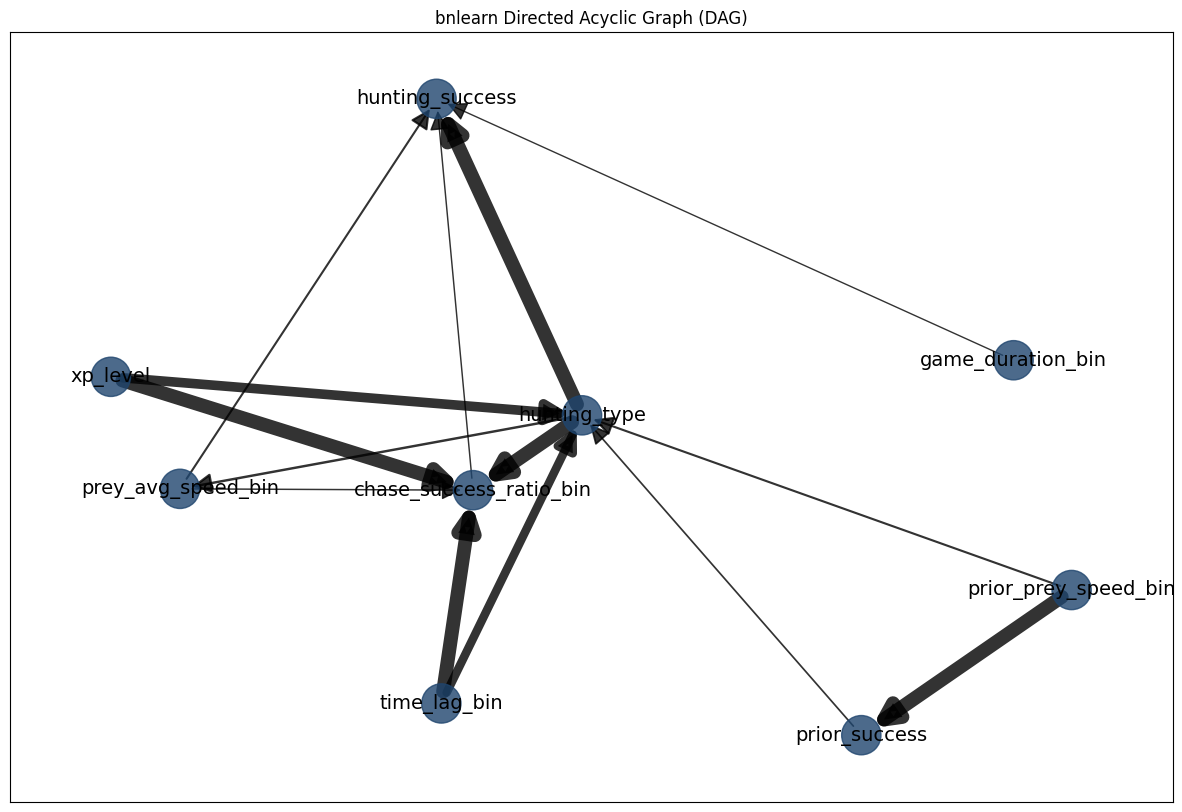

[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [g_sq] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Existing coordinates from <pos> are used.


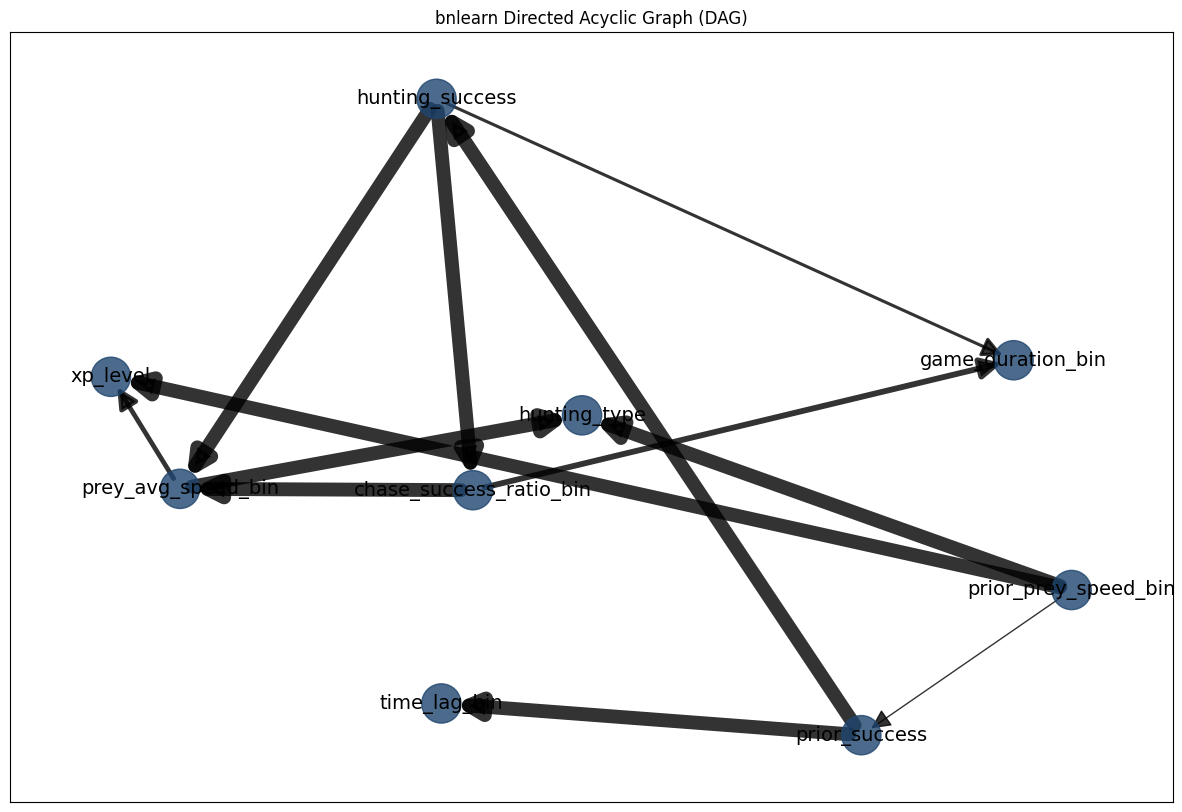

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'prior_prey_speed_bin': array([ 0.6193503 , -0.31200988]),
  'prior_success': array([ 0.35733928, -0.6997286 ]),
  'xp_level': array([-0.57757174,  0.25747056]),
  'hunting_type': array([0.00942481, 0.15459479]),
  'time_lag_bin': array([-0.16585046, -0.61498663]),
  'chase_success_ratio_bin': array([-0.12643703, -0.04533756]),
  'prey_avg_speed_bin': array([-0.49150086, -0.04173412]),
  'hunting_success': array([-0.17183589,  1.        ]),
  'game_duration_bin': array([0.54708161, 0.30173144])},
 'G': <networkx.classes.digraph.DiGraph at 0x774fd7de4dc0>,
 'node_properties': {'xp_level': {'node_color': '#1f456e', 'node_size': 800},
  'time_lag_bin': {'node_color': '#1f456e', 'node_size': 800},
  'hunting_type': {'node_color': '#1f456e', 'node_size': 800},
  'hunting_success': {'node_color': '#1f456e', 'node_size': 800},
  'prey_avg_speed_bin': {'node_color': '#1f456e', 'node_size': 800},
 

In [36]:
G = bn.plot(DAG)
#bn.compare_networks(
#    DAG,
#    DAG_lstruct,
#    pos = G["pos"]
#)
bn.plot(DAG_lstruct, pos = G["pos"])

In [50]:
# Extract the BIC
bic_expert = bn.structure_scores(
    DAG_lstruct,
    train_df,
    scoring_method="bic"
)
bic_learned = bn.structure_scores(
    DAG,
    train_df,
    scoring_method="bic"
)

# Extract the BIC values from the dictionaries
bic1 = bic_expert['bic']
bic2 = bic_learned['bic']

# Compare BIC scores
if bic1 < bic2:
    print("Model 1 has a better fit (lower BIC score) than Model 2.")
elif bic1 > bic2:
    print("Model 2 has a better fit (lower BIC score) than Model 1.")
else:
    print("Both models have the same BIC score. They are equally good in terms of fit.")

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Compute structure scores for model comparison (higher is better).
Model 2 has a better fit (lower BIC score) than Model 1.


## 6. Save the model object

In [41]:
# Save the output
dump(DAG, output_path2)

['/home/graptemys/Documents/GitHub/Chapter3/outputs/BayesNet-fit.joblib']